imports

In [1]:
try:
    import torch_xla
    import torch_xla.core.xla_model as xm

    print(f"torch_xla version: {torch_xla.__version__}")
    print(f"XLA Device: {xm.xla_device()}")
    print(f"World size: {xm.xrt_world_size()}")
except ImportError:
    print("torch_xla not installed—no TPU support in this environment.")


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


torch_xla version: 2.6.0+libtpu
XLA Device: xla:0


E0000 00:00:1745064406.333820      10 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:232


World size: 1


In [2]:
import os
import json
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.optim as optim
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Pick up the XLA device
device = xm.xla_device()
print("XLA device:", device)


XLA device: xla:0


paths

In [3]:
BASE     = '/kaggle/input/zju-leaper/ZJU-Leaper'
IMG_DIR  = BASE + '/Images'
XML_DIR  = BASE + '/Annotations/xmls'
MASK_DIR = BASE + '/Annotations/masks'
splits   = json.load(open(BASE + '/ImageSets/total.json'))

def make_pairs(ids):
    pairs = []
    for i in ids:
        img = f"{IMG_DIR}/{i}.jpg"
        root = ET.parse(f"{XML_DIR}/{i}.xml").getroot()
        if root.find('defective').text == '1':
            m = root.find('mask_filename').text
            mask = f"{MASK_DIR}/{m}"
        else:
            mask = None
        pairs.append((img, mask))
    return pairs

train_ids = splits['normal']['train'] + splits['defect']['train']
val_ids   = splits['normal']['test']  + splits['defect']['test']

train_pairs = make_pairs(train_ids)
val_pairs   = make_pairs(val_ids)
print(f"Train samples: {len(train_pairs)}, Val samples: {len(val_pairs)}")


Train samples: 63184, Val samples: 31649


build tf.data pipeline

In [4]:
class SegDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
        self.tf_img  = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
        self.tf_mask = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = self.tf_img(Image.open(img_path).convert('RGB'))
        if mask_path:
            m = self.tf_mask(Image.open(mask_path).convert('L'))
            mask = (m>0).float()
        else:
            mask = torch.zeros(1,512,512)
        return img, mask

train_ds_raw = SegDataset(train_pairs)
val_ds_raw   = SegDataset(val_pairs)
train_dl_raw = DataLoader(train_ds_raw, batch_size=4, shuffle=True,  num_workers=2)
val_dl_raw   = DataLoader(val_ds_raw,   batch_size=4, shuffle=False, num_workers=2)

train_loader = pl.ParallelLoader(train_dl_raw, [device]).per_device_loader(device)
val_loader   = pl.ParallelLoader(val_dl_raw,   [device]).per_device_loader(device)


model

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def C(in_c,out_c): return nn.Sequential(nn.Conv2d(in_c,out_c,3,padding=1), nn.ReLU(inplace=True))
        self.d1 = C(3,32);  self.p1 = nn.MaxPool2d(2)
        self.d2 = C(32,64); self.p2 = nn.MaxPool2d(2)
        self.b  = C(64,128)
        self.u1 = nn.Upsample(scale_factor=2); self.c3 = C(128+64,64)
        self.u2 = nn.Upsample(scale_factor=2); self.c4 = C(64+32,32)
        self.out= nn.Conv2d(32,1,1)

    def forward(self,x):
        c1 = self.d1(x);  p1 = self.p1(c1)
        c2 = self.d2(p1); p2 = self.p2(c2)
        b  = self.b(p2)
        u1 = self.u1(b);  u1 = torch.cat([u1,c2],dim=1); c3 = self.c3(u1)
        u2 = self.u2(c3); u2 = torch.cat([u2,c1],dim=1); c4 = self.c4(u2)
        return torch.sigmoid(self.out(c4))

model = UNet().to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters()))


UNet(
  (d1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (u1): Upsample(scale_factor=2.0, mode='nearest')
  (c3): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (u2): Upsample(scale_factor=2.0, mode='nearest')
  (c4): Sequential(
    (0): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)
Params: 231617


summary

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


train and save history

In [3]:
EPOCHS = 20
best_val = 1e9
train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    tot_loss = 0.0
    for imgs, masks in train_loader:
        optimizer.zero_grad()
        preds = model(imgs)
        loss  = criterion(preds, masks)
        loss.backward()
        xm.optimizer_step(optimizer)  # XLA step
        tot_loss += loss.item() * imgs.size(0)
    train_loss = tot_loss / len(train_ds_raw)
    train_hist.append(train_loss)

    # eval
    model.eval()
    tot_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            preds = model(imgs)
            tot_val += criterion(preds, masks).item() * imgs.size(0)
    val_loss = tot_val / len(val_ds_raw)
    val_hist.append(val_loss)

    # checkpoint
    if val_loss < best_val:
        best_val = val_loss
        xm.save(model.state_dict(), '/kaggle/working/unet_tpu_best.pt')

    print(f"Epoch {epoch}: train={train_loss:.4f}, val={val_loss:.4f}")


Epoch 1: train=0.0911, val=0.0739
Epoch 2: train=0.0000, val=0.0000
Epoch 3: train=0.0000, val=0.0000
Epoch 4: train=0.0000, val=0.0000
Epoch 5: train=0.0000, val=0.0000
Epoch 6: train=0.0000, val=0.0000
Epoch 7: train=0.0000, val=0.0000
Epoch 8: train=0.0000, val=0.0000
Epoch 9: train=0.0000, val=0.0000
Epoch 10: train=0.0000, val=0.0000
Epoch 11: train=0.0000, val=0.0000
Epoch 12: train=0.0000, val=0.0000
Epoch 13: train=0.0000, val=0.0000
Epoch 14: train=0.0000, val=0.0000
Epoch 15: train=0.0000, val=0.0000
Epoch 16: train=0.0000, val=0.0000
Epoch 17: train=0.0000, val=0.0000
Epoch 18: train=0.0000, val=0.0000
Epoch 19: train=0.0000, val=0.0000
Epoch 20: train=0.0000, val=0.0000


In [8]:
torch.save(model.state_dict(), '/kaggle/working/unet_final.pth')
print("Weights saved to /kaggle/working/unet_final.pth")
'''
model = UNet().to(device)
model.load_state_dict(torch.load('/kaggle/working/unet_final.pth', map_location=device))
model.eval()
'''

torch.save(model, '/kaggle/working/unet_full.pth')
print("Full model saved to /kaggle/working/unet_full.pth")


Weights saved to /kaggle/working/unet_final.pth
Full model saved to /kaggle/working/unet_full.pth


plot training curves

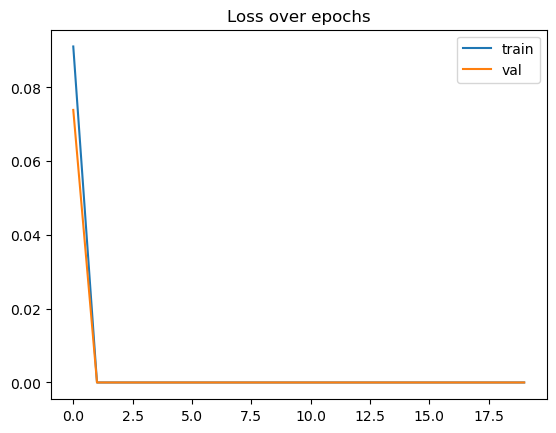

In [9]:
plt.plot(train_hist, label='train')
plt.plot(val_hist,   label='val')
plt.legend(); plt.title('Loss over epochs'); plt.show()


visualize some preds

  → train batches: 15796
  →  val batches: 7913


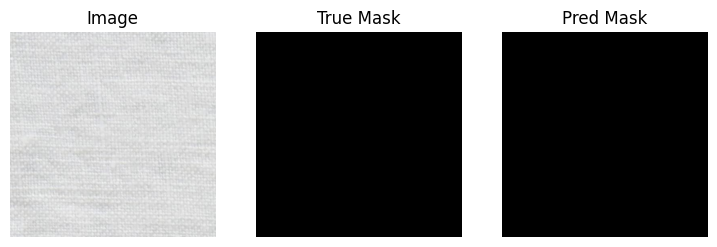

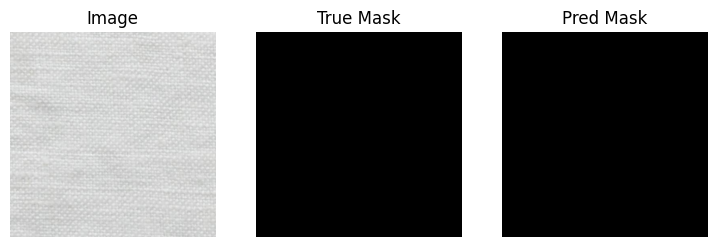

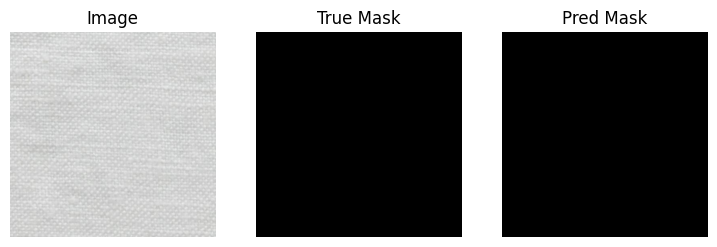

In [17]:
# note this code is being generated by chatgpt
train_dl_raw = DataLoader(
    train_ds_raw,
    batch_size=4,
    shuffle=True,
    drop_last=False,
    num_workers=2,
)
val_dl_raw = DataLoader(
    val_ds_raw,
    batch_size=4,
    shuffle=False,
    drop_last=False,
    num_workers=2,
)

print("  → train batches:", len(train_dl_raw))
print("  →  val batches:", len(val_dl_raw))

def get_one_batch_on_tpu(raw_loader, device):
    tpu_loader = ParallelLoader(raw_loader, [device]).per_device_loader(device)
    try:
        imgs, masks = next(iter(tpu_loader))
    except StopIteration:
        raise RuntimeError(
            f"Wrapped loader is empty—even though raw has "
            f"{len(raw_loader.dataset)} samples and {len(raw_loader)} batches."
        )
    return imgs, masks


cpu_checkpoint = torch.load(
    '/kaggle/working/unet_tpu_best.pt',
    map_location={'xla:0': 'cpu'}
)
model.load_state_dict(cpu_checkpoint)
model.to(device)
model.eval()

imgs, masks = get_one_batch_on_tpu(val_dl_raw, device)

with torch.no_grad():
    preds = model(imgs)

imgs_cpu  = imgs.cpu().numpy()
masks_cpu = masks.cpu().numpy()
preds_cpu = preds.cpu().numpy()

for i in range(min(3, imgs_cpu.shape[0])):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(imgs_cpu[i].transpose(1, 2, 0))
    axes[0].set_title('Image');     axes[0].axis('off')
    axes[1].imshow(masks_cpu[i,0], cmap='gray')
    axes[1].set_title('True Mask'); axes[1].axis('off')
    axes[2].imshow((preds_cpu[i,0]>0.5).astype(float), cmap='gray')
    axes[2].set_title('Pred Mask'); axes[2].axis('off')
    plt.show()


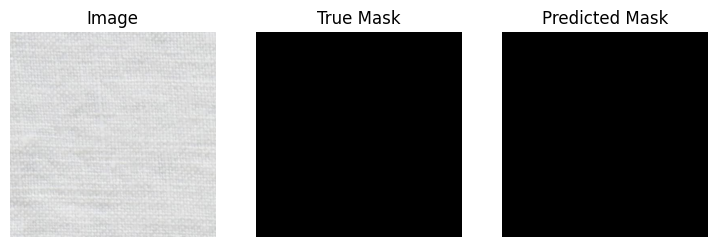

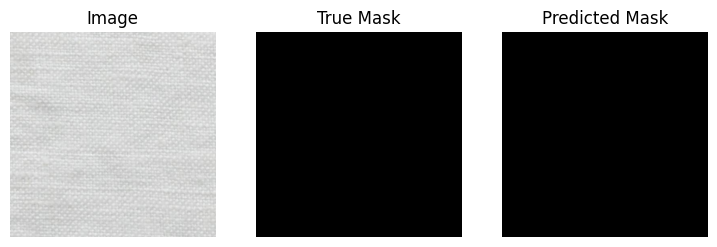

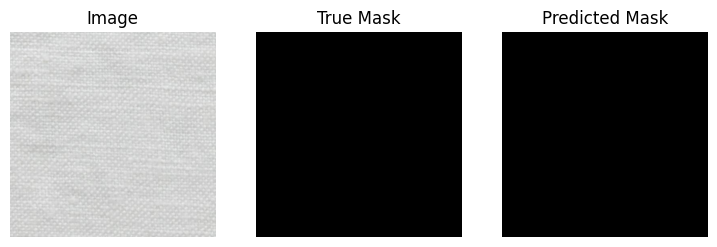

In [19]:
# load best checkpoint
'''
state = torch.load('/kaggle/working/unet_tpu_best.pt', map_location=device)
model.load_state_dict(state)
model.eval()'''
model.load_state_dict(torch.load('/kaggle/working/unet_tpu_best.pt', map_location=device))
model.to(device)
model.eval()

imgs, masks = next(iter(val_loader))
with torch.no_grad():
    preds = model(imgs)

for i in range(3):
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(imgs[i].permute(1,2,0).cpu());    plt.title('Image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(masks[i,0].cpu(), cmap='gray');   plt.title('True');  plt.axis('off')
    plt.subplot(1,3,3); plt.imshow((preds[i,0]>0.5).cpu(), cmap='gray'); plt.title('Pred'); plt.axis('off')
    plt.show()


In [20]:
from torch_xla.distributed.parallel_loader import ParallelLoader

def evaluate_pixel_accuracy(model, raw_loader, device):
    model.eval()
    total_correct = 0
    total_pixels  = 0

    tpu_loader = ParallelLoader(raw_loader, [device]).per_device_loader(device)

    with torch.no_grad():
        for imgs, masks in tpu_loader:
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()
            # accumulate matches and total
            total_correct += (preds_bin == masks).sum().item()
            total_pixels  += masks.numel()

    return total_correct / total_pixels

accuracy = evaluate_pixel_accuracy(model, val_dl_raw, device)
print(f"Validation pixel accuracy: {accuracy:.4f}")


Validation pixel accuracy: 0.9847


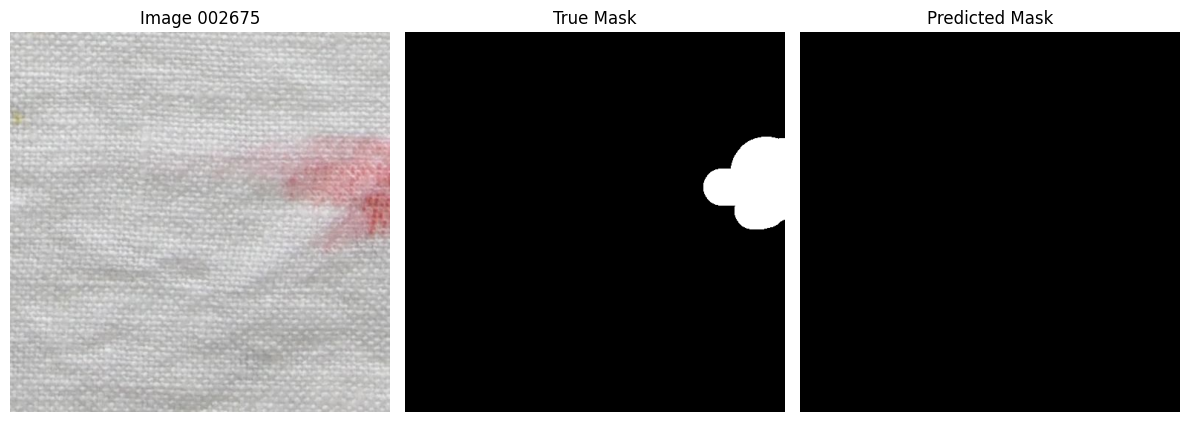

In [25]:
tf_img = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
tf_mask = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

checkpoint = torch.load('/kaggle/working/unet_tpu_best.pt', map_location='cpu')
state_dict = checkpoint if 'state_dict' not in checkpoint else checkpoint['state_dict']
model.load_state_dict(state_dict)
model.to(device)
model.eval()

img_id = '002675'

img = Image.open(f"{IMG_DIR}/{img_id}.jpg").convert('RGB')

# masks via xml
root = ET.parse(f"{XML_DIR}/{img_id}.xml").getroot()
if root.find('defective').text == '1':
    mask_fn = root.find('mask_filename').text
    mask = Image.open(f"{MASK_DIR}/{mask_fn}").convert('L')
else:
    # create an empty mask for non-defective images
    mask = Image.new('L', img.size, 0)

img_t  = tf_img(img).unsqueeze(0).to(device) 
mask_t = tf_mask(mask)[0]                    

with torch.no_grad():
    pred_logits = model(img_t)    
pred_prob = torch.sigmoid(pred_logits)[0,0] 
pred_bin  = (pred_prob > 0.5).cpu().numpy()

img_np  = img_t[0].cpu().permute(1,2,0).numpy()
mask_np = mask_t.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(img_np)
axes[0].set_title(f'Image {img_id}')
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(pred_bin, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [26]:
import torch
from torch_xla.distributed.parallel_loader import ParallelLoader

def evaluate_iou_and_dice(model, raw_loader, device, threshold=0.5):
    
    model.eval()
    total_inter  = 0.0
    total_union  = 0.0
    total_sum    = 0.0  

    
    tpu_loader = ParallelLoader(raw_loader, [device]).per_device_loader(device)

    with torch.no_grad():
        for imgs, masks in tpu_loader:
           
            preds = (model(imgs) > threshold).float()

            # flatte
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # intersection & union for IoU
            inter = (preds_flat * masks_flat).sum().item()
            union = ((preds_flat + masks_flat) >= 1).sum().item()

            # sums for Dice
            sum_preds_masks = preds_flat.sum().item() + masks_flat.sum().item()

            total_inter += inter
            total_union += union
            total_sum   += sum_preds_masks

    iou  = total_inter / total_union if total_union > 0 else 0.0
    dice = (2 * total_inter) / total_sum   if total_sum   > 0 else 0.0
    return iou, dice

iou, dice = evaluate_iou_and_dice(model, val_dl_raw, device)
print(f"Validation IoU:  {iou:.4f}")
print(f"Validation Dice: {dice:.4f}")


Validation IoU:  0.1793
Validation Dice: 0.3040


Image 002675 @0.5 →  IoU:  0.0372,  Dice: 0.0718
  @ thresh=0.2: IoU=0.0372, Dice=0.0718
  @ thresh=0.3: IoU=0.0372, Dice=0.0718
  @ thresh=0.4: IoU=0.0372, Dice=0.0718
  @ thresh=0.5: IoU=0.0372, Dice=0.0718


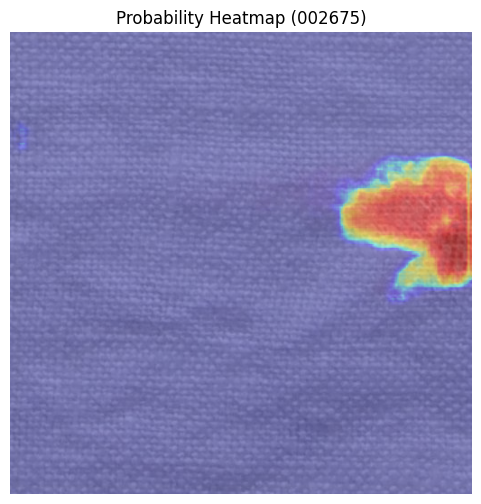

In [27]:
# note this code is being taken from chatgpt.
import numpy as np
import matplotlib.pyplot as plt

true = mask_np.astype(bool)
prob = pred_prob.cpu().numpy()
pred_bin = prob > 0.5
inter   = np.logical_and(pred_bin, true).sum()
union   = np.logical_or (pred_bin, true).sum()
iou_05  = inter / union if union else 0.0
dice_05 = 2*inter / (pred_bin.sum() + true.sum()) if (pred_bin.sum()+true.sum())>0 else 0.0

print(f"Image 002675 @0.5 →  IoU:  {iou_05:.4f},  Dice: {dice_05:.4f}")

for t in [0.2, 0.3, 0.4, 0.5]:
    pb = prob > t
    inter = np.logical_and(pb, true).sum()
    union = np.logical_or (pb, true).sum()
    iou   = inter/union if union else 0.0
    dice  = 2*inter/(pb.sum()+true.sum()) if (pb.sum()+true.sum())>0 else 0.0
    print(f"  @ thresh={t:.1f}: IoU={iou:.4f}, Dice={dice:.4f}")


plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.imshow(prob, cmap='jet', alpha=0.4)
plt.title('Probability Heatmap (002675)')
plt.axis('off')
plt.show()
